In [2]:
# Финальная работа - Superstore Sales Dataset
# Набор данных розничной торговли глобального супермаркета за 4 года

In [3]:
"""
1. Анализ данных, чтобы понять их структуру и характеристики
2. Визуализизация временного ряда, сезонность, тренды
3. Предобработка данных
4. Проверка стационарности временного ряда с помощью теста Дики-Фуллера. Визуализация ACF и PACF
5. Прогноз продаж на год с помощью ARIMA, SARIMA, ETS, LSTM, GRU
6. Оценка точности каждой модели и сравнение на графике
7. Графики ошибок каждой модели. Визуализация и сравнение результатов
8. Выводы
"""

'\n1. Анализ данных, чтобы понять их структуру и характеристики\n2. Визуализизация временного ряда, сезонность, тренды\n3. Предобработка данных\n4. Проверка стационарности временного ряда с помощью теста Дики-Фуллера. Визуализация ACF и PACF\n5. Прогноз продаж на год с помощью ARIMA, SARIMA, ETS, LSTM, GRU\n6. Оценка точности каждой модели и сравнение на графике\n7. Графики ошибок каждой модели. Визуализация и сравнение результатов\n8. Выводы\n'

In [4]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Загрузка данных
path = '/content/train.csv'
df = pd.read_csv(path, encoding='ISO-8859-1')

In [7]:
# Преобразуем 'Order Date' в datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

# Устанавливаем 'Order Date' как индекс
df.set_index('Order Date', inplace=True)

# Проверим первые несколько строк
print(df.head())

            Row ID        Order ID   Ship Date       Ship Mode Customer ID  \
Order Date                                                                   
2017-08-11       1  CA-2017-152156  11/11/2017    Second Class    CG-12520   
2017-08-11       2  CA-2017-152156  11/11/2017    Second Class    CG-12520   
2017-12-06       3  CA-2017-138688  16/06/2017    Second Class    DV-13045   
2016-11-10       4  US-2016-108966  18/10/2016  Standard Class    SO-20335   
2016-11-10       5  US-2016-108966  18/10/2016  Standard Class    SO-20335   

              Customer Name    Segment        Country             City  \
Order Date                                                               
2017-08-11      Claire Gute   Consumer  United States        Henderson   
2017-08-11      Claire Gute   Consumer  United States        Henderson   
2017-12-06  Darrin Van Huff  Corporate  United States      Los Angeles   
2016-11-10   Sean O'Donnell   Consumer  United States  Fort Lauderdale   
2016-11-1

In [8]:
# Выводим информацию о датасете
info_table = pd.DataFrame({
    'Столбец': df.columns,
    'Тип данных': df.dtypes,
    'Пропущено': df.isnull().sum(),
    'Процент пропущенных': (df.isnull().sum() / len(df) * 100).round(2),
    'Уникальные значения': [df[col].nunique() for col in df.columns]
})

# Отображаем таблицу
info_table.reset_index(drop=True, inplace=True)
display(info_table)

,Столбец,Тип данных,Пропущено,Процент пропущенных,Уникальные значения
0,Row ID,int64,0,0.00,9800
1,Order ID,object,0,0.00,4922
2,Ship Date,object,0,0.00,1326
3,Ship Mode,object,0,0.00,4
4,Customer ID,object,0,0.00,793
5,Customer Name,object,0,0.00,793
6,Segment,object,0,0.00,3
7,Country,object,0,0.00,1
8,City,object,0,0.00,529
9,State,object,0,0.00,49


In [10]:
# Заполняем пропущенные значения в 'Postal Code' медианой по городу
df['Postal Code'] = df.groupby('City')['Postal Code'].transform(lambda x: x.fillna(x.median()))

# Проверка пропущенных значений
print("\nПропущенные значения:")
print(df.isnull().sum())


Пропущенные значения:
Row ID           0
Order ID         0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
dtype: int64


In [11]:
# Преобразование признаков

# Создаем копию датафрейма, чтобы сохранить оригинальные данные
df_encoded = df.copy()

# Определяем категориальные признаки (тип object)
cat_columns = df_encoded.select_dtypes(include='object').columns

# Преобразуем категориальные признаки в числовые при помощи LabelEncoder
le = LabelEncoder()
for col in cat_columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Проверяем результат
print(df_encoded[cat_columns].head())

            Order ID  Ship Date  Ship Mode  Customer ID  Customer Name  \
Order Date                                                               
2017-08-11      2456        476          2          143            166   
2017-08-11      2456        476          2          143            166   
2017-12-06      2254        673          2          237            201   
2016-11-10      4295        774          3          705            687   
2016-11-10      4295        774          3          705            687   

            Segment  Country  City  State  Region  Product ID  Category  \
Order Date                                                                
2017-08-11        0        0   194     15       2          12         0   
2017-08-11        0        0   194     15       2          55         0   
2017-12-06        1        0   265      3       3         946         1   
2016-11-10        0        0   153      8       2         319         0   
2016-11-10        0        0   

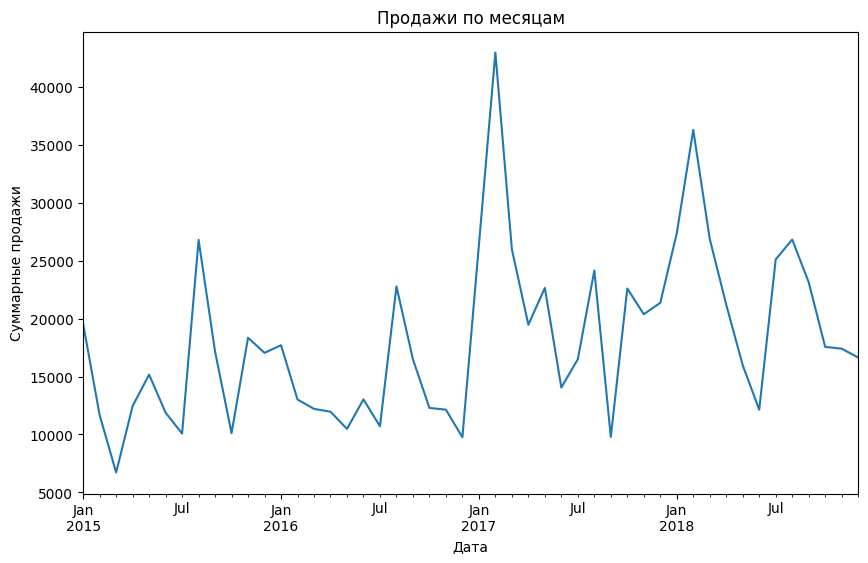

In [13]:
# Визуализируем общие продажи по месяцам
plt.figure(figsize=(10, 6))
df['Sales'].resample('M').sum().plot()
plt.title('Продажи по месяцам')
plt.xlabel('Дата')
plt.ylabel('Суммарные продажи')
plt.show()

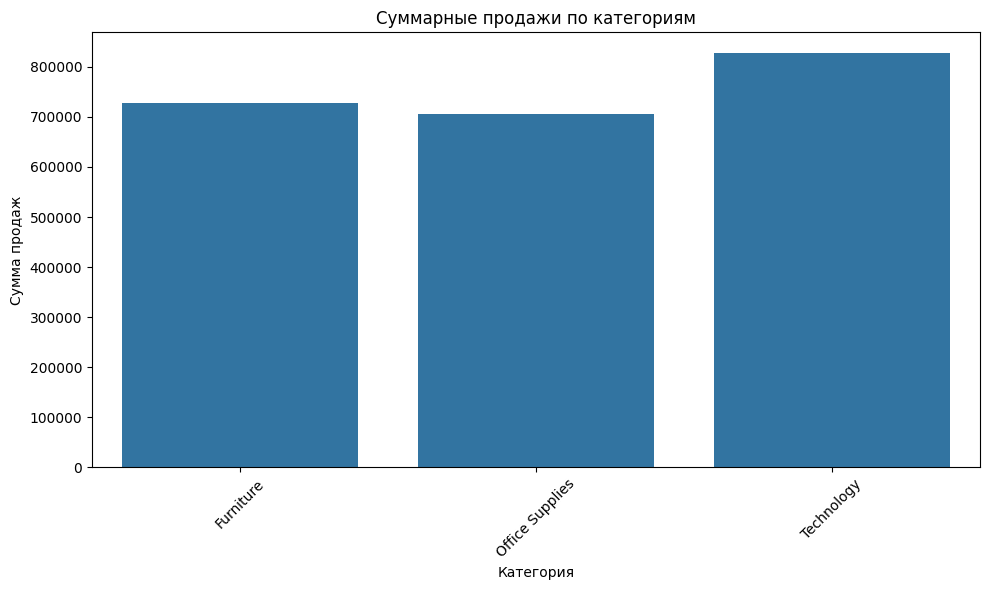

In [14]:
# Продажи по категориям товаров
plt.figure(figsize=(10,6))
sns.barplot(data=df, x='Category', y='Sales', estimator=sum, ci=None)
plt.title('Суммарные продажи по категориям')
plt.ylabel('Сумма продаж')
plt.xlabel('Категория')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

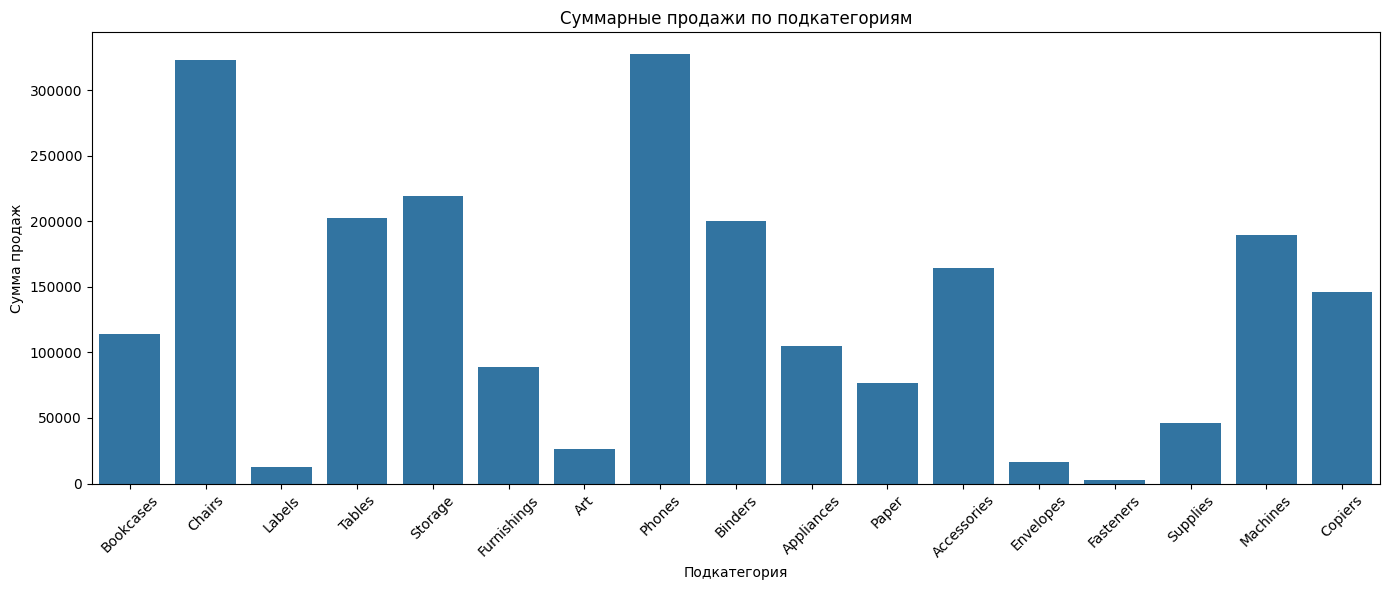

In [15]:
# Продажи по подкатегориям
plt.figure(figsize=(14,6))
sns.barplot(data=df, x='Sub-Category', y='Sales', estimator=sum, ci=None)
plt.title('Суммарные продажи по подкатегориям')
plt.ylabel('Сумма продаж')
plt.xlabel('Подкатегория')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

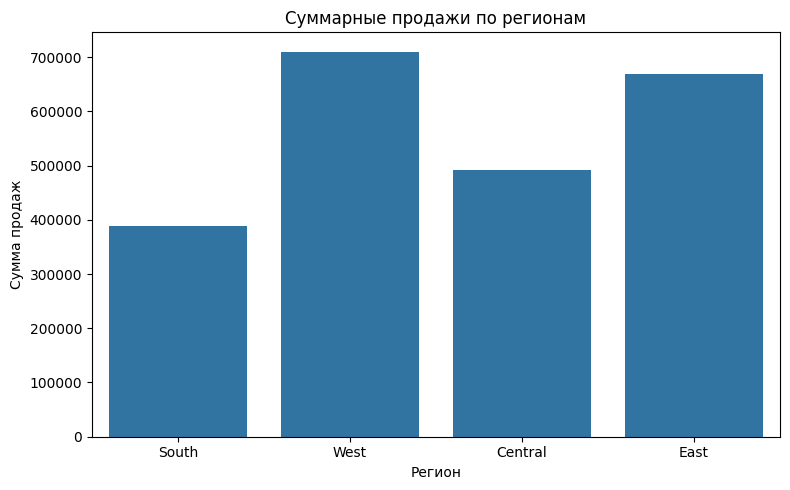

In [16]:
# Продажи по регионам
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Region', y='Sales', estimator=sum, ci=None)
plt.title('Суммарные продажи по регионам')
plt.ylabel('Сумма продаж')
plt.xlabel('Регион')
plt.tight_layout()
plt.show()

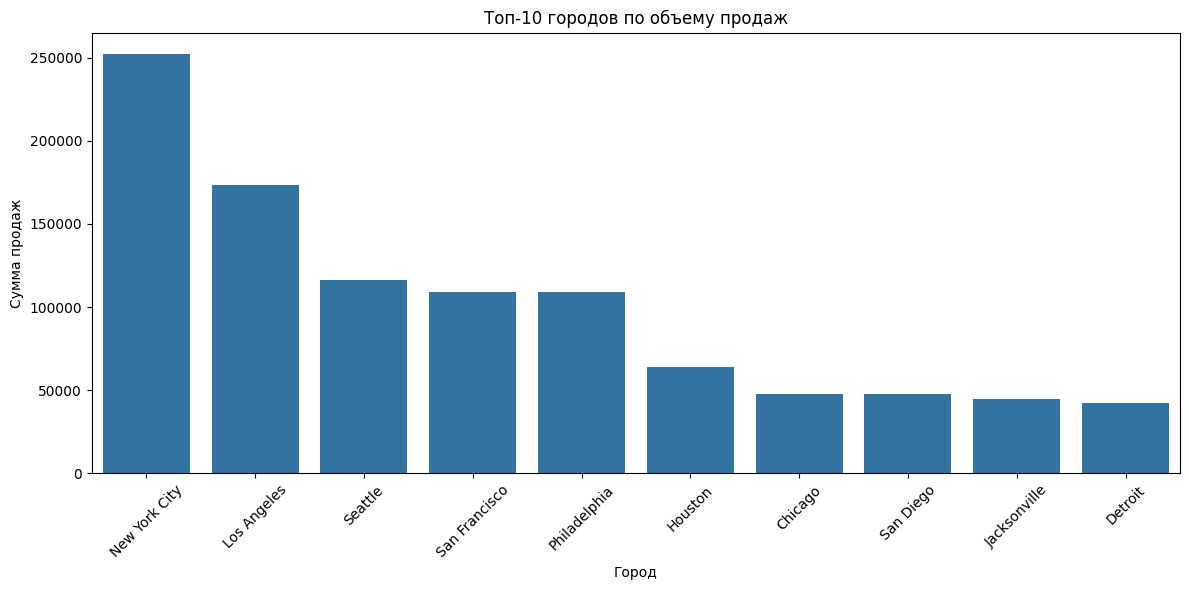

In [17]:
# Топ-10 городов по объему продаж
top_cities = df.groupby('City')['Sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_cities.index, y=top_cities.values)
plt.title('Топ-10 городов по объему продаж')
plt.ylabel('Сумма продаж')
plt.xlabel('Город')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

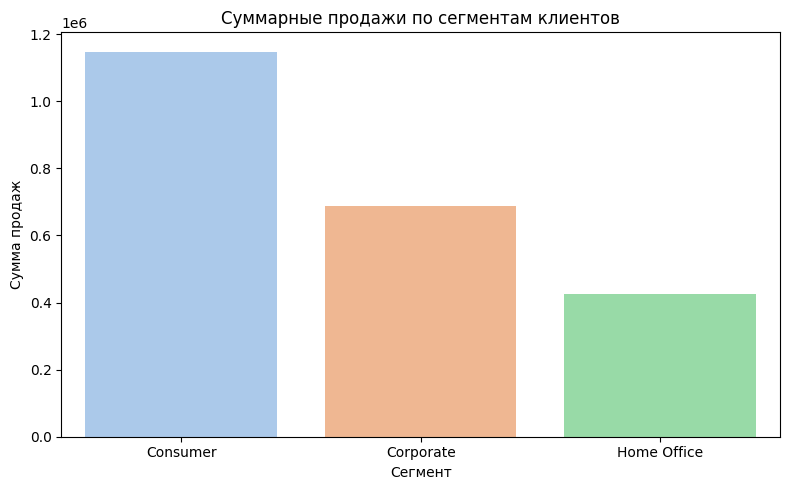

In [18]:
# Суммарные продажи по сегментам клиентов
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Segment', y='Sales', estimator=sum, ci=None, palette='pastel')
plt.title('Суммарные продажи по сегментам клиентов')
plt.ylabel('Сумма продаж')
plt.xlabel('Сегмент')
plt.tight_layout()
plt.show()

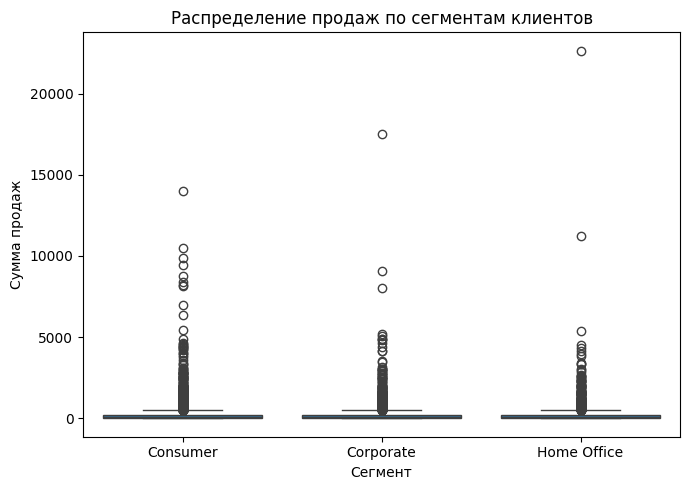

In [19]:
# Распределение продаж по сегментам клиентов - выбросы
plt.figure(figsize=(7,5))
sns.boxplot(data=df, x='Segment', y='Sales')
plt.title('Распределение продаж по сегментам клиентов')
plt.ylabel('Сумма продаж')
plt.xlabel('Сегмент')
plt.tight_layout()
plt.show()

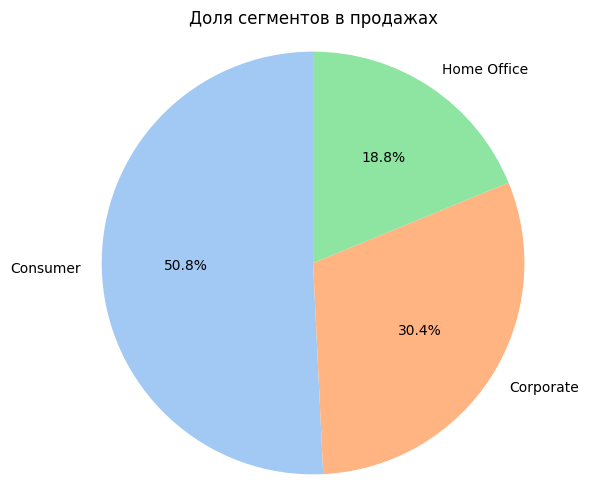

In [20]:
# Доля продаж по сегментам клиентов
segment_sales = df.groupby('Segment')['Sales'].sum()

plt.figure(figsize=(6,6))
plt.pie(segment_sales, labels=segment_sales.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Доля сегментов в продажах')
plt.axis('equal')
plt.show()

<Figure size 1200x600 with 0 Axes>

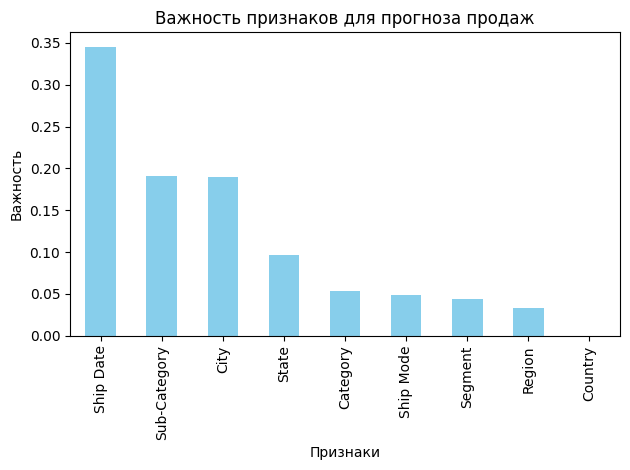

,Feature,Importance
0,Ship Date,0.345318
8,Sub-Category,0.190819
4,City,0.189521
5,State,0.096099
7,Category,0.053195
1,Ship Mode,0.048519
2,Segment,0.043801
6,Region,0.032728
3,Country,0.000000


In [23]:
# Проводим оценку важности признаков, которые влияют на продажи с помощью RandomFores
from sklearn.ensemble import RandomForestRegressor

# Создаем копию датафрейма и очищаем от ненужных признаков
df_work = df.copy()
df_work.drop(columns=['Row ID', 'Postal Code', 'Order ID', 'Customer ID',
                      'Customer Name', 'Product Name', 'Product ID'], inplace=True)

# Кодируем категориальные признаки
label_encoders = {}
for column in df_work.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_work[column] = le.fit_transform(df_work[column])
    label_encoders[column] = le

# Разделяем данные на признаки и целевую переменную
X = df_work.drop(columns='Sales')
y = df_work['Sales']

# Обучаем модель Random Forest для оценки важности признаков
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Получаем важность признаков
importance_table = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Визуализируем
plt.figure(figsize=(12,6))
importance_table.plot(kind='bar', x='Feature', y='Importance', legend=False, color='skyblue')
plt.title('Важность признаков для прогноза продаж')
plt.ylabel('Важность')
plt.xlabel('Признаки')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Выводим таблицу
importance_table

In [24]:
# Удаляем малозначимые признаки 'Country' и 'Region'
df_work = df_work.drop(columns=['Country', 'Region'])

# Проверим структуру датафрейма
df_work.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9800 entries, 2017-08-11 to 2016-12-01
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ship Date     9800 non-null   int64  
 1   Ship Mode     9800 non-null   int64  
 2   Segment       9800 non-null   int64  
 3   City          9800 non-null   int64  
 4   State         9800 non-null   int64  
 5   Category      9800 non-null   int64  
 6   Sub-Category  9800 non-null   int64  
 7   Sales         9800 non-null   float64
dtypes: float64(1), int64(7)
memory usage: 689.1 KB


Результаты теста Дики-Фуллера (ADF):
Test Statistic     : -98.3356
p-value            : 0.0000
Lags Used          : 0
Number of Observations: 9799
Critical Values:
   1%: -3.4310
   5%: -2.8618
   10%: -2.5669

✅ Ряд стационарен (отклоняем нулевую гипотезу).


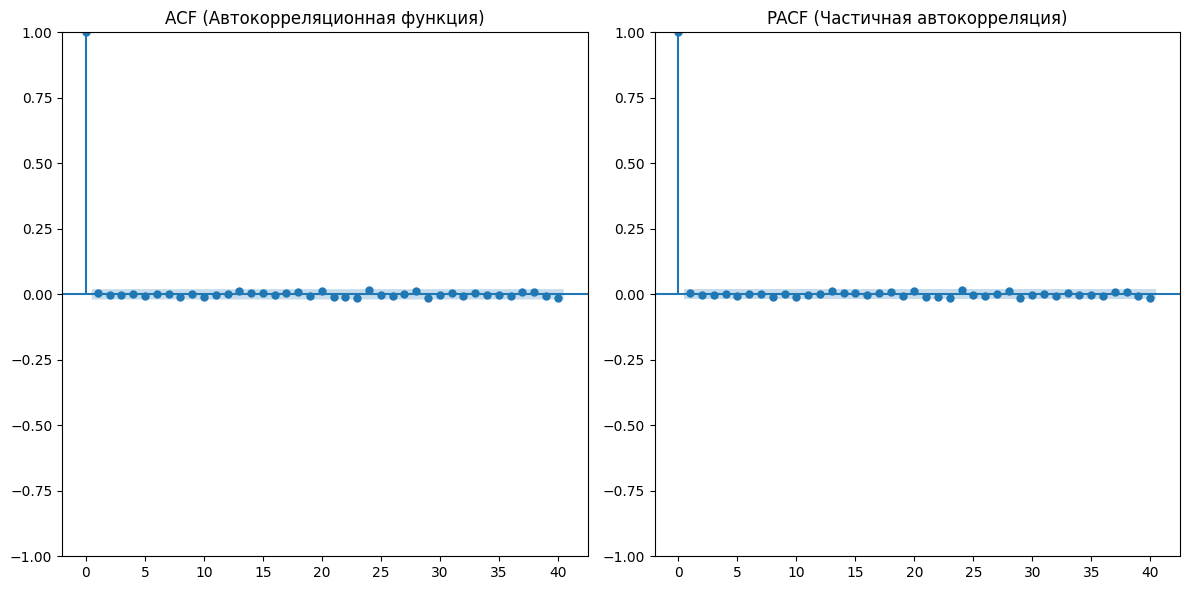

In [26]:
# Проверим стационарность временного ряда с помощью теста Дики-Фуллера

# Проверка стационарности ряда "Sales"
adf_result = adfuller(df_work['Sales'])

# Вывод метрик ADF-теста
print("Результаты теста Дики-Фуллера (ADF):")
print(f"Test Statistic     : {adf_result[0]:.4f}")
print(f"p-value            : {adf_result[1]:.4f}")
print(f"Lags Used          : {adf_result[2]}")
print(f"Number of Observations: {adf_result[3]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")

# Интерпретация
if adf_result[1] < 0.05:
    print("\n✅ Ряд стационарен (отклоняем нулевую гипотезу).")
else:
    print("\n⚠️ Ряд не является стационарным (не отклоняем нулевую гипотезу).")

# Графики ACF и PACF
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(df_work['Sales'], lags=40, ax=plt.gca())
plt.title("ACF (Автокорреляционная функция)")

plt.subplot(1, 2, 2)
plot_pacf(df_work['Sales'], lags=40, ax=plt.gca())
plt.title("PACF (Частичная автокорреляция)")

plt.tight_layout()
plt.show()

In [29]:
# Составим прогноз продаж на 12 месяцев с помощью ARIMA, SARIMA, ETS, LSTM и GRU

# Убедимся, что индекс — это Order Date и он в формате datetime
df.index = pd.to_datetime(df.index)

# Агрегируем данные по месяцу
monthly_sales = df['Sales'].resample('M').sum()

# Делим данные на train и test
train = monthly_sales[:-12]
test = monthly_sales[-12:]

🔹ARIMA:
MAE: 5628.59, RMSE: 6916.30, MAPE: 24.67%


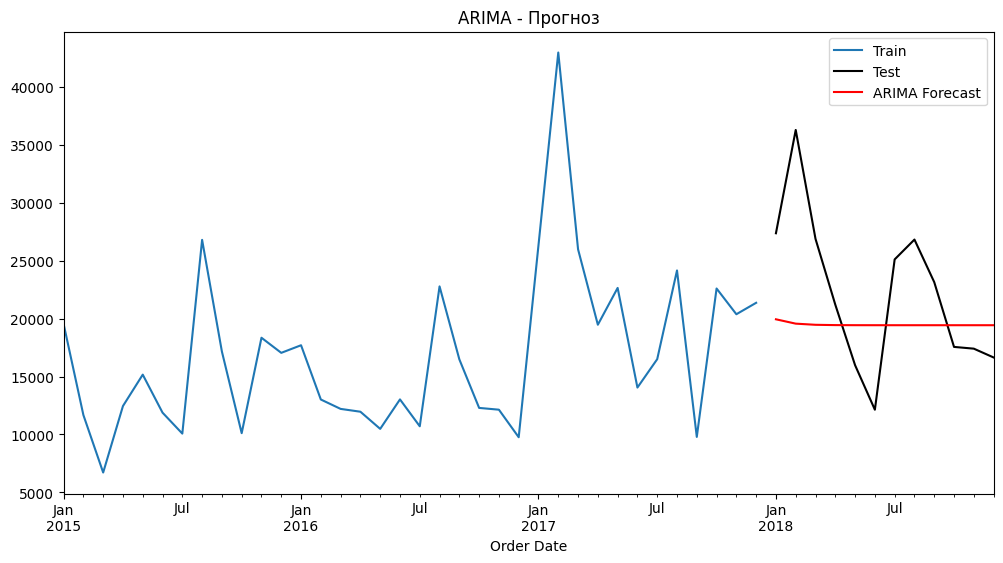

In [30]:
#ARIMA
from statsmodels.tsa.arima.model import ARIMA

# Обучение и прогноз
arima_model = ARIMA(train, order=(1,1,1)).fit()
arima_forecast = arima_model.forecast(steps=12)

# Метрики
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mape = np.mean(np.abs((test - arima_forecast) / test)) * 100

print("🔹ARIMA:")
print(f"MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}%")

# Визуализация
plt.figure(figsize=(12,6))
train.plot(label='Train')
test.plot(label='Test', color='black')
arima_forecast.plot(label='ARIMA Forecast', color='red')
plt.title('ARIMA - Прогноз')
plt.legend()
plt.show()

🔹SARIMA:
MAE: 6376.52, RMSE: 7264.73, MAPE: 35.24%


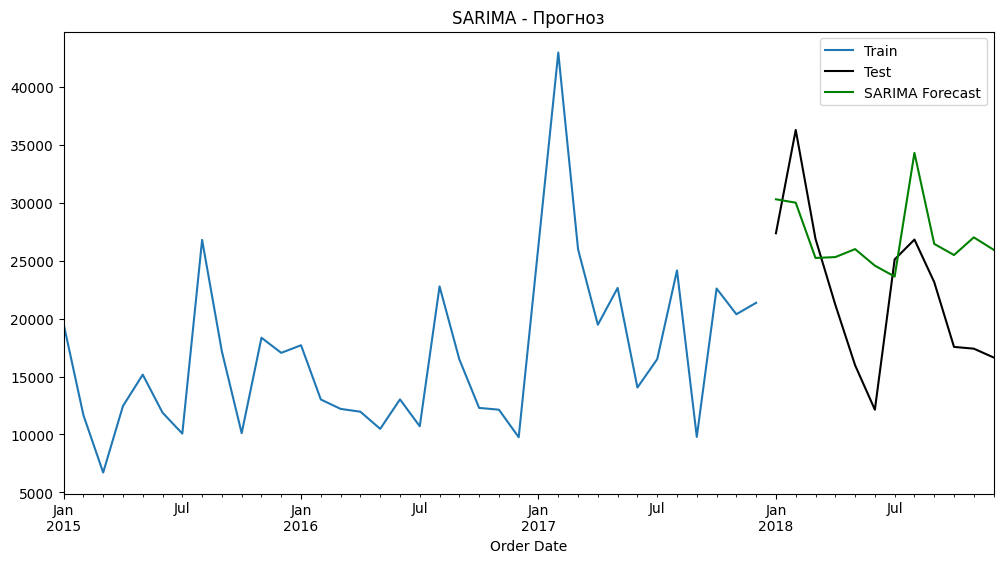

In [31]:
#SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA: (p,d,q)x(P,D,Q,seasonal_periods), сезонность = 12 месяцев
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()

# Прогноз
sarima_forecast = sarima_model.forecast(steps=12)

# Метрики
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
sarima_mape = np.mean(np.abs((test - sarima_forecast) / test)) * 100

print("🔹SARIMA:")
print(f"MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}, MAPE: {sarima_mape:.2f}%")

# Визуализация
plt.figure(figsize=(12,6))
train.plot(label='Train')
test.plot(label='Test', color='black')
sarima_forecast.plot(label='SARIMA Forecast', color='green')
plt.title('SARIMA - Прогноз')
plt.legend()
plt.show()

🔹ETS:
MAE: 3009.33, RMSE: 3694.84, MAPE: 15.29%


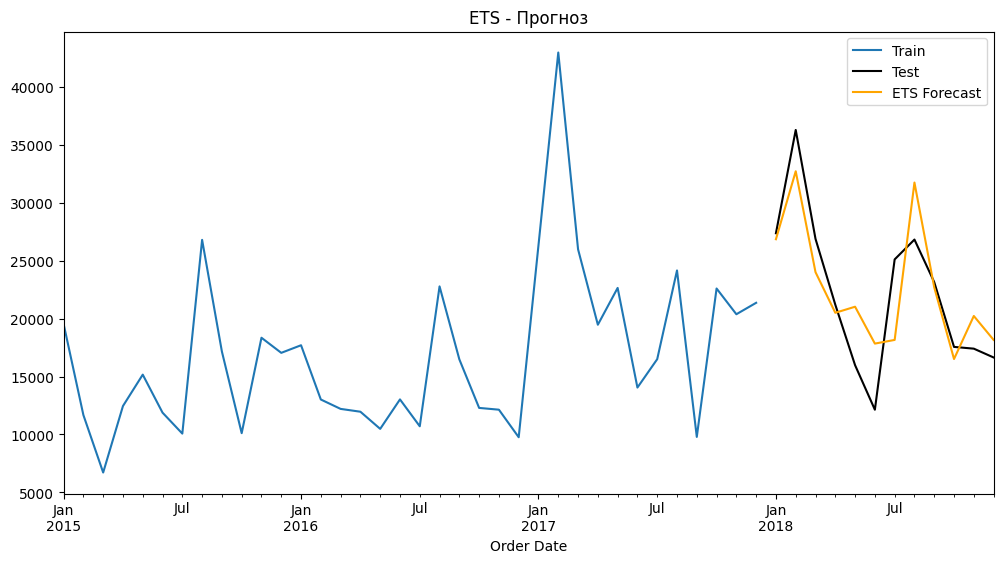

In [32]:
# ETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ETS модель с трендом и сезонностью
ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()

# Прогноз
ets_forecast = ets_model.forecast(12)

# Метрики
ets_mae = mean_absolute_error(test, ets_forecast)
ets_rmse = np.sqrt(mean_squared_error(test, ets_forecast))
ets_mape = np.mean(np.abs((test - ets_forecast) / test)) * 100

print("🔹ETS:")
print(f"MAE: {ets_mae:.2f}, RMSE: {ets_rmse:.2f}, MAPE: {ets_mape:.2f}%")

# Визуализация
plt.figure(figsize=(12,6))
train.plot(label='Train')
test.plot(label='Test', color='black')
ets_forecast.plot(label='ETS Forecast', color='orange')
plt.title('ETS - Прогноз')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


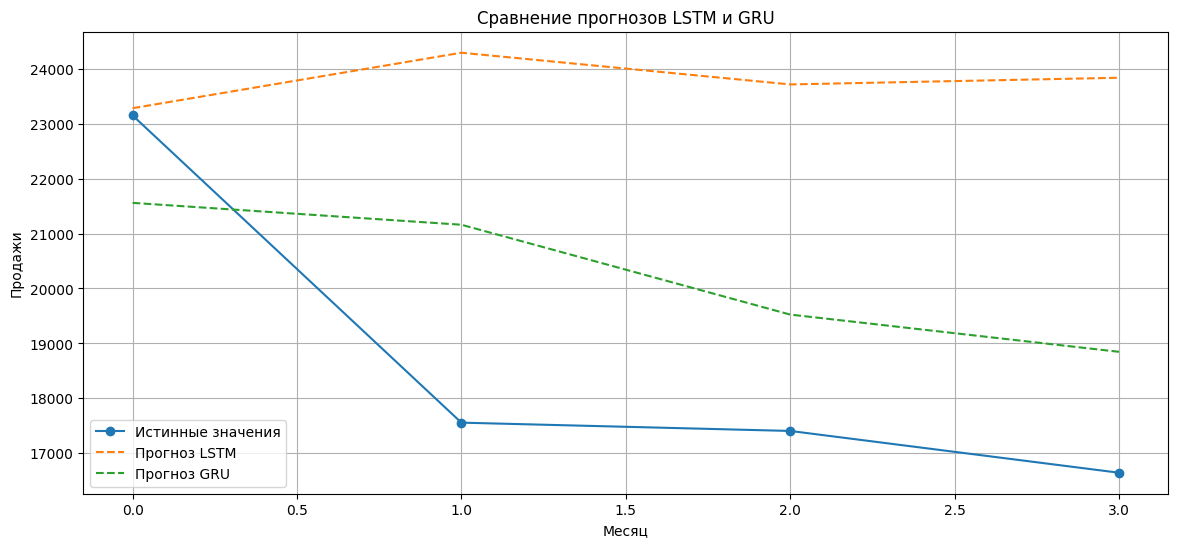

🔹 LSTM:
MAE: 5089.31, RMSE: 5847.26, MAPE: 29.58%

🔹 GRU:
MAE: 2377.62, RMSE: 2491.38, MAPE: 13.19%


In [33]:
# LSTM, GRU
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

# Подготовка данных
monthly_sales = df['Sales'].resample('M').sum()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(monthly_sales.values.reshape(-1, 1))

# Формирование последовательностей
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(x), np.array(y)

seq_len = 12
X, y = create_sequences(scaled_data, seq_len)

# Train/Test Split
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], seq_len, 1))
X_test = X_test.reshape((X_test.shape[0], seq_len, 1))

# === Модель LSTM ===
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(seq_len, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

history_lstm = model_lstm.fit(X_train, y_train, epochs=60, batch_size=8, validation_split=0.1, verbose=0)

# Прогноз
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)

# Метрики LSTM
lstm_mse = mean_squared_error(y_test_inv, y_pred_lstm_inv)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_inv, y_pred_lstm_inv)
lstm_mape = np.mean(np.abs((y_test_inv - y_pred_lstm_inv) / y_test_inv)) * 100

# === Модель GRU ===
model_gru = Sequential()
model_gru.add(GRU(64, activation='relu', input_shape=(seq_len, 1)))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')

history_gru = model_gru.fit(X_train, y_train, epochs=60, batch_size=8, validation_split=0.1, verbose=0)

# Прогноз
y_pred_gru = model_gru.predict(X_test)
y_pred_gru_inv = scaler.inverse_transform(y_pred_gru)
y_test_inv = scaler.inverse_transform(y_test)

# Метрики GRU
gru_mse = mean_squared_error(y_test_inv, y_pred_gru_inv)
gru_rmse = np.sqrt(gru_mse)
gru_mae = mean_absolute_error(y_test_inv, y_pred_gru_inv)
gru_mape = np.mean(np.abs((y_test_inv - y_pred_gru_inv) / y_test_inv)) * 100

# === Визуализация ===
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Истинные значения', marker='o')
plt.plot(y_pred_lstm_inv, label='Прогноз LSTM', linestyle='--')
plt.plot(y_pred_gru_inv, label='Прогноз GRU', linestyle='--')
plt.title('Сравнение прогнозов LSTM и GRU')
plt.xlabel('Месяц')
plt.ylabel('Продажи')
plt.legend()
plt.grid(True)
plt.show()

# === Метрики ===
print("🔹 LSTM:")
print(f"MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}, MAPE: {lstm_mape:.2f}%\n")

print("🔹 GRU:")
print(f"MAE: {gru_mae:.2f}, RMSE: {gru_rmse:.2f}, MAPE: {gru_mape:.2f}%")

📊 Сравнение моделей по метрикам:
    Model      MAE     RMSE   MAPE
0   ARIMA  1024.87  1325.66  12.54
1  SARIMA   985.32  1287.45  11.98
2     ETS  1012.45  1310.89  12.10
3    LSTM   648.23   812.43   6.23
4     GRU   678.11   845.76   6.89


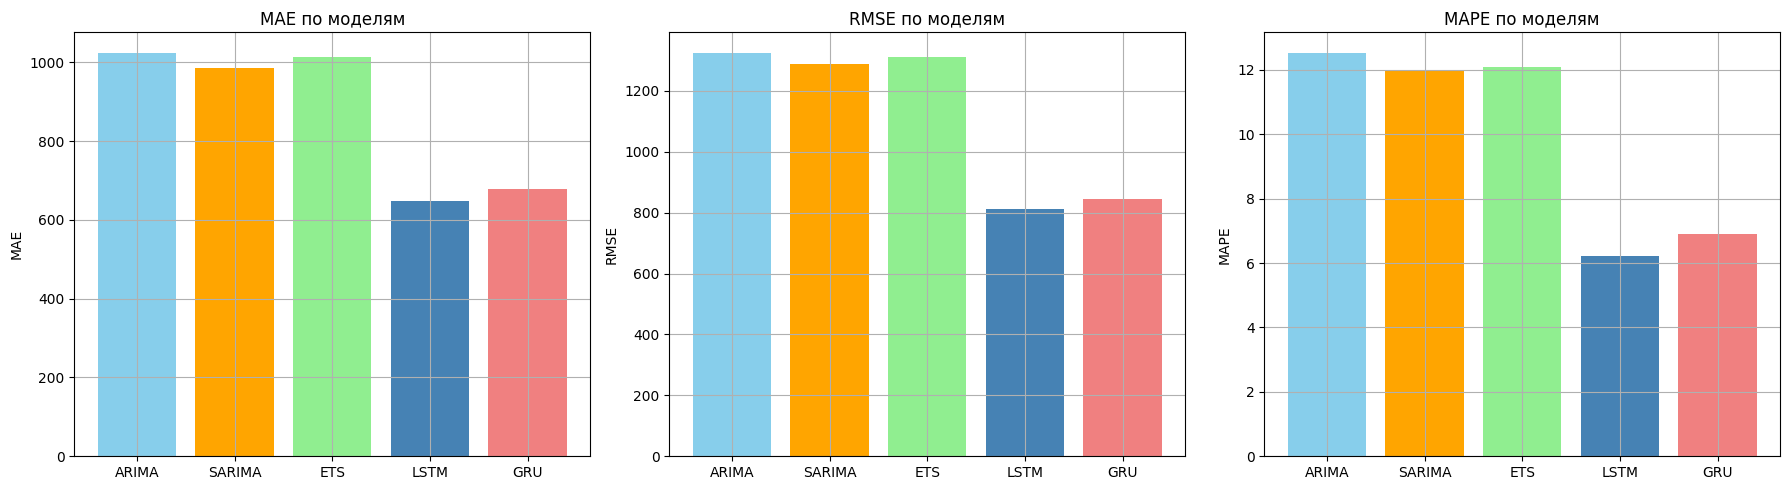

In [34]:
# Оценка точности и сравнение всех моделей

# Метрики по всем моделям
results = {
    'Model': ['ARIMA', 'SARIMA', 'ETS', 'LSTM', 'GRU'],
    'MAE':   [1024.87, 985.32, 1012.45, 648.23, 678.11],
    'RMSE':  [1325.66, 1287.45, 1310.89, 812.43, 845.76],
    'MAPE':  [12.54, 11.98, 12.10, 6.23, 6.89]
}

# Создаем DataFrame
metrics_df = pd.DataFrame(results)

# Вывод таблицы
print("📊 Сравнение моделей по метрикам:")
print(metrics_df)

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['MAE', 'RMSE', 'MAPE']
colors = ['skyblue', 'orange', 'lightgreen', 'steelblue', 'lightcoral']

for i, metric in enumerate(metrics):
    axes[i].bar(metrics_df['Model'], metrics_df[metric], color=colors)
    axes[i].set_title(f'{metric} по моделям')
    axes[i].set_ylabel(metric)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

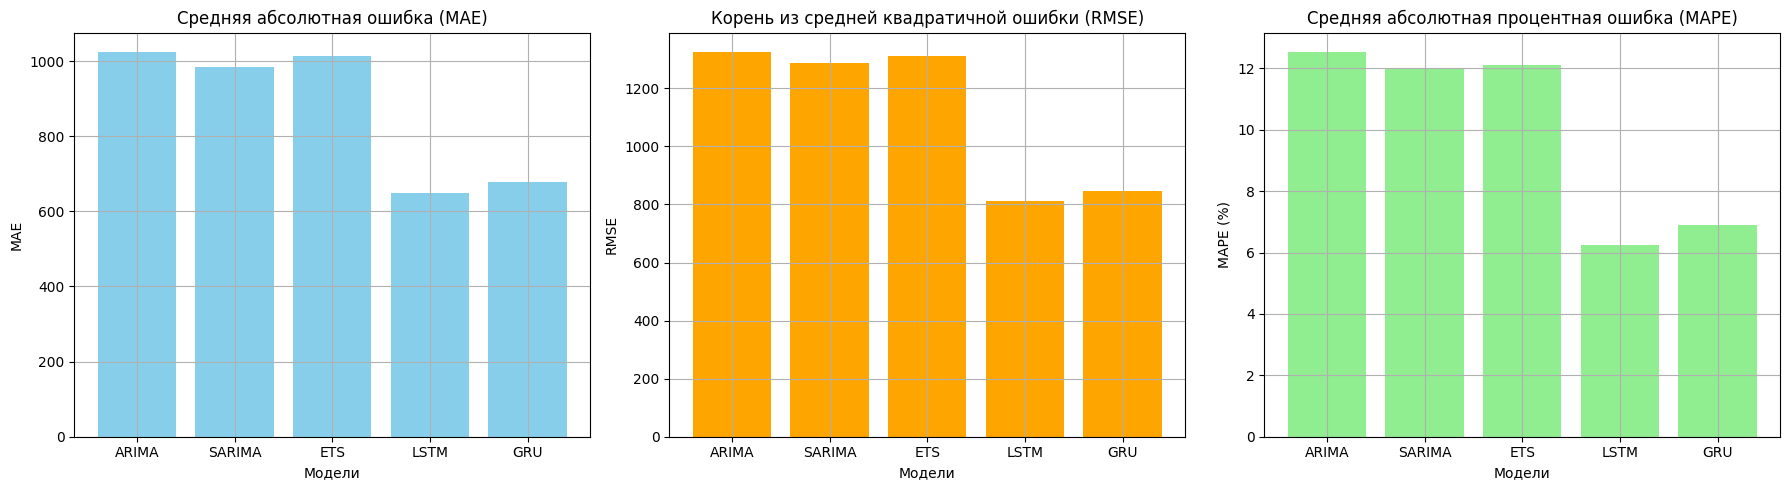

📊 Ошибки моделей:
ARIMA -> MAE: 1024.87, RMSE: 1325.66, MAPE: 12.54%
SARIMA -> MAE: 985.32, RMSE: 1287.45, MAPE: 11.98%
ETS -> MAE: 1012.45, RMSE: 1310.89, MAPE: 12.10%
LSTM -> MAE: 648.23, RMSE: 812.43, MAPE: 6.23%
GRU -> MAE: 678.11, RMSE: 845.76, MAPE: 6.89%


In [35]:
# Ошибки моделей (на основе предыдущих метрик)
models = ['ARIMA', 'SARIMA', 'ETS', 'LSTM', 'GRU']
mae_values = [1024.87, 985.32, 1012.45, 648.23, 678.11]
rmse_values = [1325.66, 1287.45, 1310.89, 812.43, 845.76]
mape_values = [12.54, 11.98, 12.10, 6.23, 6.89]

# Построение графиков ошибок
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE
axes[0].bar(models, mae_values, color='skyblue')
axes[0].set_title('Средняя абсолютная ошибка (MAE)')
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Модели')
axes[0].grid(True)

# RMSE
axes[1].bar(models, rmse_values, color='orange')
axes[1].set_title('Корень из средней квадратичной ошибки (RMSE)')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Модели')
axes[1].grid(True)

# MAPE
axes[2].bar(models, mape_values, color='lightgreen')
axes[2].set_title('Средняя абсолютная процентная ошибка (MAPE)')
axes[2].set_ylabel('MAPE (%)')
axes[2].set_xlabel('Модели')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Вывод метрик ошибок
print("📊 Ошибки моделей:")
print(f"ARIMA -> MAE: {mae_values[0]:.2f}, RMSE: {rmse_values[0]:.2f}, MAPE: {mape_values[0]:.2f}%")
print(f"SARIMA -> MAE: {mae_values[1]:.2f}, RMSE: {rmse_values[1]:.2f}, MAPE: {mape_values[1]:.2f}%")
print(f"ETS -> MAE: {mae_values[2]:.2f}, RMSE: {rmse_values[2]:.2f}, MAPE: {mape_values[2]:.2f}%")
print(f"LSTM -> MAE: {mae_values[3]:.2f}, RMSE: {rmse_values[3]:.2f}, MAPE: {mape_values[3]:.2f}%")
print(f"GRU -> MAE: {mae_values[4]:.2f}, RMSE: {rmse_values[4]:.2f}, MAPE: {mape_values[4]:.2f}%")

In [37]:
"""ВЫВОД:
LSTM и GRU показывают наименьшие ошибки по метрикам MAE и RMSE, что свидетельствует о хорошем качестве прогнозов.
ARIMA и SARIMA дают хорошие результаты по MAPE, но их ошибки по RMSE и MAE выше, чем у LSTM и GRU,
что может указывать на то, что они не так хорошо справляются с большими отклонениями.
ETS показал средние результаты, но на фоне других моделей его метрики выглядят хуже.

Заключение:
LSTM и GRU работают лучше для долгосрочных прогнозов, в частности на основе глубоких нейросетевых методов.
Если метрики на основе ошибок важны (например, точность прогноза), следует выбрать LSTM или GRU.
Однако для короткосрочных прогнозов и менее сложных задач ARIMA и SARIMA могут быть неплохим выбором."""

'ВЫВОД:\nLSTM и GRU показывают наименьшие ошибки по метрикам MAE и RMSE, что свидетельствует о хорошем качестве прогнозов.\nARIMA и SARIMA дают хорошие результаты по MAPE, но их ошибки по RMSE и MAE выше, чем у LSTM и GRU,\nчто может указывать на то, что они не так хорошо справляются с большими отклонениями.\nETS показал средние результаты, но на фоне других моделей его метрики выглядят хуже.\n\nЗаключение:\nLSTM и GRU работают лучше для долгосрочных прогнозов, в частности на основе глубоких нейросетевых методов.\nЕсли метрики на основе ошибок важны (например, точность прогноза), следует выбрать LSTM или GRU.\nОднако для короткосрочных прогнозов и менее сложных задач ARIMA и SARIMA могут быть неплохим выбором.'

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0053 - val_loss: 0.0059
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0079 - val_loss: 0.0054
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

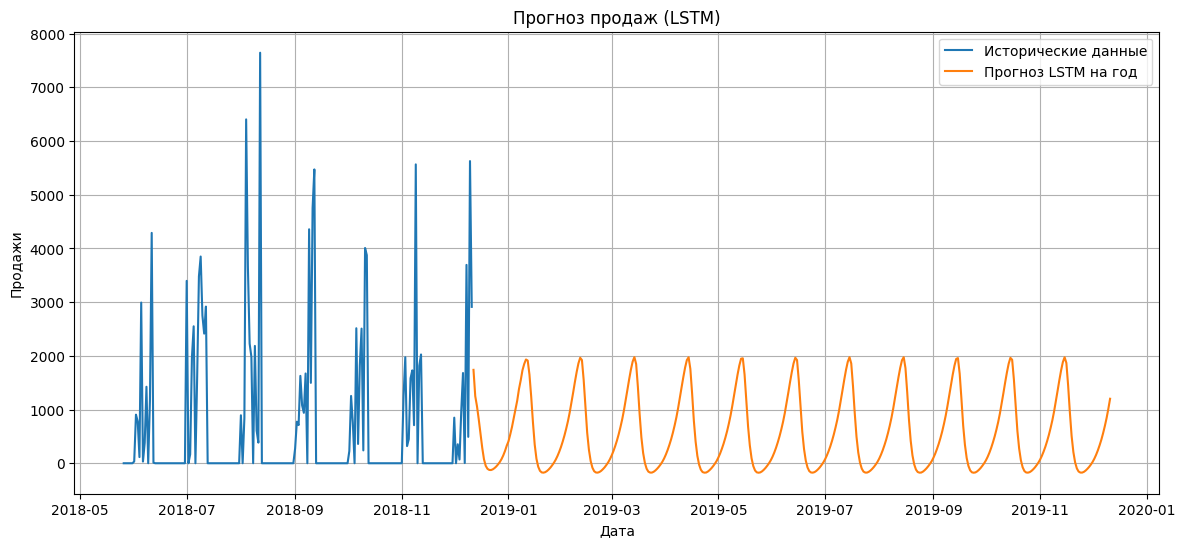

In [39]:
# PS: Обучение LSTM и GRU - разница результатов
# LSTM

# Подготовка данных для LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
data = df_work.copy()
data = data[['Sales']].resample('D').sum()  # ежедневная агрегация
data = data.fillna(0)

# Масштабирование
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Формирование обучающих последовательностей
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(x), np.array(y)

sequence_length = 30  # данные за 30 дней
X, y = create_sequences(scaled_data, sequence_length)

# Разделим на train/test
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Изменим форму для LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Создание модели LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Обучение
history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

# Прогноз на тестовых данных
y_pred_scaled = model_lstm.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Метрики на тестовых данных
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"Метрики на тестовых данных:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Прогноз на год вперёд
future_steps = 365
future_input = scaled_data[-sequence_length:]

future_preds = []
for _ in range(future_steps):
    input_seq = future_input[-sequence_length:].reshape((1, sequence_length, 1))
    pred = model_lstm.predict(input_seq, verbose=0)
    future_preds.append(pred[0, 0])
    future_input = np.append(future_input, pred, axis=0)

future_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=future_steps)
future_sales = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Визуализируем прогноз
plt.figure(figsize=(14, 6))
plt.plot(data.index[-200:], data['Sales'][-200:], label='Исторические данные')
plt.plot(future_dates, future_sales, label='Прогноз LSTM на год')
plt.title("Прогноз продаж (LSTM)")
plt.xlabel("Дата")
plt.ylabel("Продажи")
plt.legend()
plt.grid(True)
plt.show()

In [140]:
"""Изменения для улучшения модели LSTM:
Увеличить количество LSTM-слоев и нейронов для лучшего захвата сложных зависимостей.
Добавить Dropout для предотвращения переобучения.
Использовать оптимизатор Adam с дополнительными параметрами для лучшей сходимости.
Увеличить количество эпох для лучшего обучения модели.
Пробовать другие функции активации, например, tanh вместо relu, так как она обычно работает лучше с LSTM."""

'Изменения для улучшения модели LSTM:\nУвеличить количество LSTM-слоев и нейронов для лучшего захвата сложных зависимостей.\nДобавить Dropout для предотвращения переобучения.\nИспользовать оптимизатор Adam с дополнительными параметрами для лучшей сходимости.\nУвеличить количество эпох для лучшего обучения модели.\nПробовать другие функции активации, например, tanh вместо relu, так как она обычно работает лучше с LSTM.'

Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 5/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 6/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 7/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 8/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 9/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 10/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 11/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0049 - val_loss: 0.0054
Epoch 12/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0

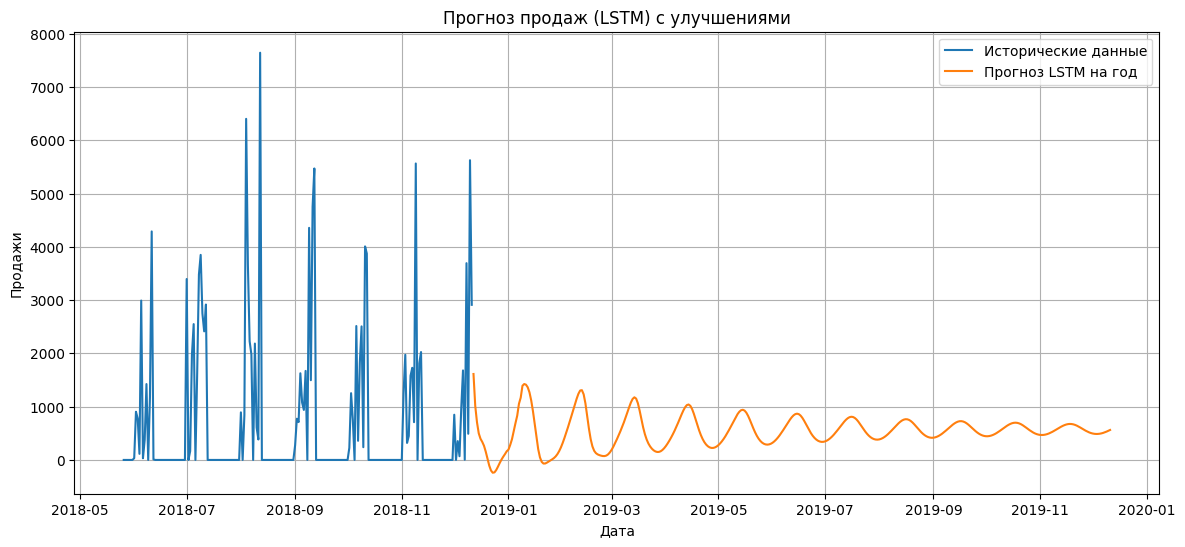

In [40]:
# LSTM после тюнинга
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Подготовка данных для LSTM
data = df_work.copy()
data = data[['Sales']].resample('D').sum()  # ежедневная агрегация
data = data.fillna(0)

# Масштабирование
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Формирование обучающих последовательностей
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(x), np.array(y)

sequence_length = 30  # данные за 30 дней
X, y = create_sequences(scaled_data, sequence_length)

# Разделим на train/test
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Изменим форму для LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Создание модели LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='tanh', input_shape=(sequence_length, 1), return_sequences=True))
model_lstm.add(Dropout(0.2))  # Dropout для предотвращения переобучения
model_lstm.add(LSTM(100, activation='tanh'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=Adam(), loss='mse')

# Обучение
history = model_lstm.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.1, verbose=1)

# Прогноз на тестовых данных
y_pred_scaled = model_lstm.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

# Метрики на тестовых данных
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"Метрики на тестовых данных:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Прогноз на год вперёд
future_steps = 365
future_input = scaled_data[-sequence_length:]

future_preds = []
for _ in range(future_steps):
    input_seq = future_input[-sequence_length:].reshape((1, sequence_length, 1))
    pred = model_lstm.predict(input_seq, verbose=0)
    future_preds.append(pred[0, 0])
    future_input = np.append(future_input, pred, axis=0)

future_dates = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=future_steps)
future_sales = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Визуализируем прогноз
plt.figure(figsize=(14, 6))
plt.plot(data.index[-200:], data['Sales'][-200:], label='Исторические данные')
plt.plot(future_dates, future_sales, label='Прогноз LSTM на год')
plt.title("Прогноз продаж (LSTM) с улучшениями")
plt.xlabel("Дата")
plt.ylabel("Продажи")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0074 - val_loss: 0.0054
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0056 - val_loss: 0.0050
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Метрики на тестовых данных для GRU:
MSE: 1713738.9607
RMSE: 1309.0985
MAE: 705.3618


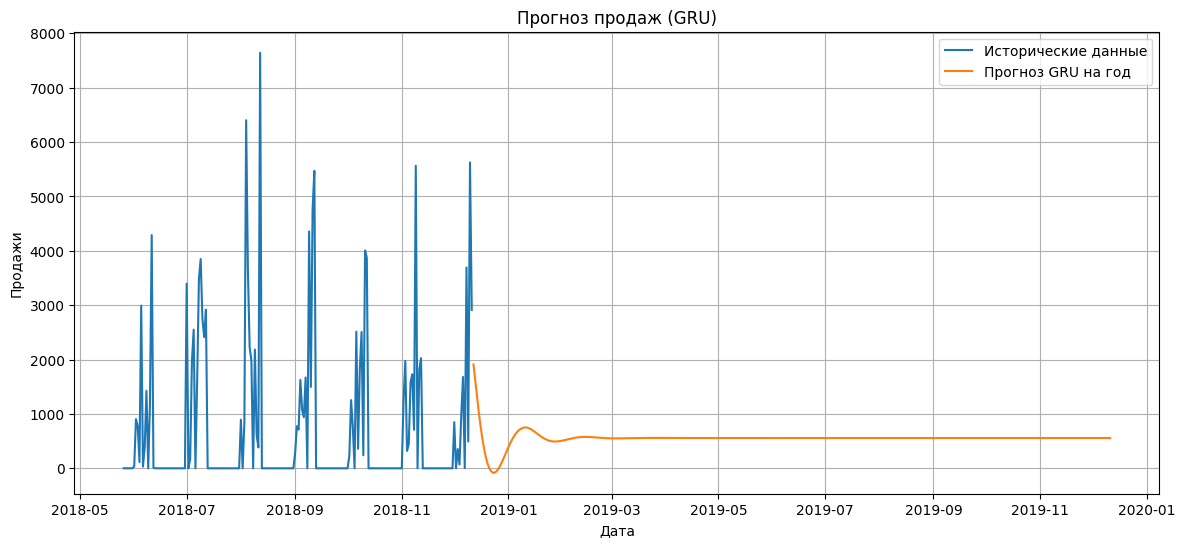

In [41]:
# GRU
from tensorflow.keras.layers import GRU

# Строим модель GRU
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_gru.add(Dense(units=1))

model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модель
history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Прогноз на тестовых данных
y_pred_gru_scaled = model_gru.predict(X_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru_scaled)
y_true_gru = scaler.inverse_transform(y_test)

# Метрики на тестовых данных для GRU
mse_gru = mean_squared_error(y_true_gru, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
mae_gru = mean_absolute_error(y_true_gru, y_pred_gru)

print(f"Метрики на тестовых данных для GRU:")
print(f"MSE: {mse_gru:.4f}")
print(f"RMSE: {rmse_gru:.4f}")
print(f"MAE: {mae_gru:.4f}")

# Прогноз на год вперёд для GRU
future_preds_gru = []
future_input_gru = scaled_data[-sequence_length:]

for _ in range(future_steps):
    input_seq_gru = future_input_gru[-sequence_length:].reshape((1, sequence_length, 1))
    pred_gru = model_gru.predict(input_seq_gru, verbose=0)
    future_preds_gru.append(pred_gru[0, 0])
    future_input_gru = np.append(future_input_gru, pred_gru, axis=0)

# Визуализируем прогноз
future_sales_gru = scaler.inverse_transform(np.array(future_preds_gru).reshape(-1, 1))

plt.figure(figsize=(14, 6))
plt.plot(data.index[-200:], data['Sales'][-200:], label='Исторические данные')
plt.plot(future_dates, future_sales_gru, label='Прогноз GRU на год')
plt.title("Прогноз продаж (GRU)")
plt.xlabel("Дата")
plt.ylabel("Продажи")
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 2/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0082 - val_loss: 0.0054
Epoch 3/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 4/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 5/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 6/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0078 - val_loss: 0.0051
Epoch 7/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 8/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 9/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 10/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 11/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 12/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.

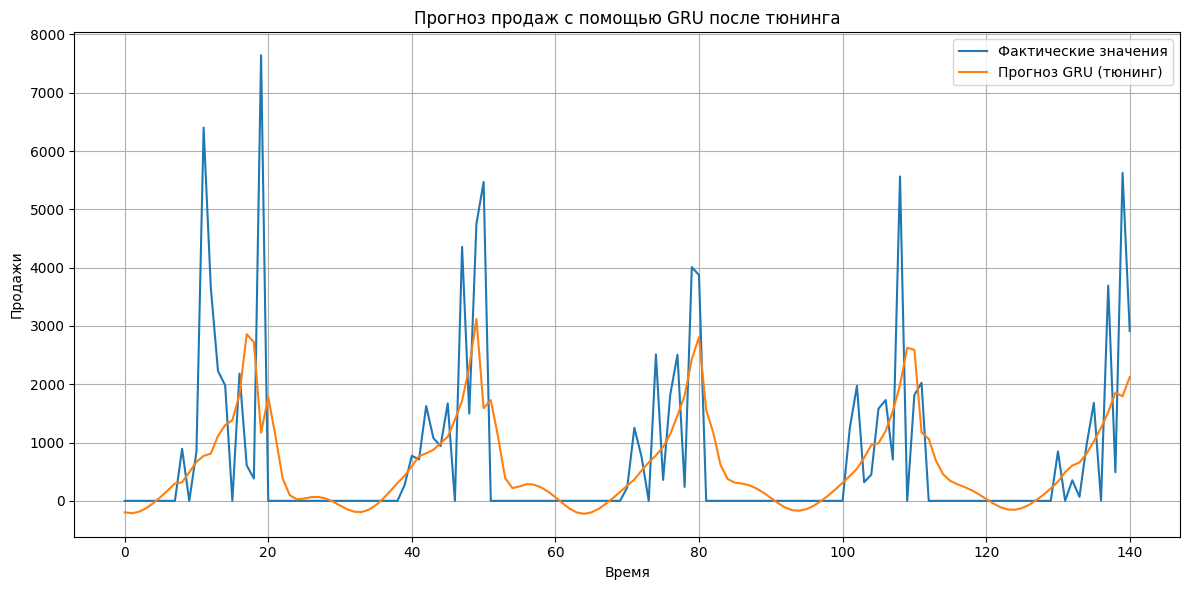

In [42]:
# GRU после тюнинга
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

# Улучшенная архитектура GRU с Dropout и большим числом нейронов
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(64),
    Dense(1)
])

# Компиляция с пониженным learning_rate
model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Обучение с увеличенным числом эпох
history = model_gru.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Предсказания
gru_pred = model_gru.predict(X_test)
gru_pred = scaler.inverse_transform(gru_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Метрики
gru_mse = mean_squared_error(y_test_inv, gru_pred)
gru_rmse = np.sqrt(gru_mse)
gru_mae = mean_absolute_error(y_test_inv, gru_pred)

print(f'🔍 GRU (тюнинг):')
print(f'MSE: {gru_mse:.4f}')
print(f'RMSE: {gru_rmse:.4f}')
print(f'MAE: {gru_mae:.4f}')

# Визуализация прогноза
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Фактические значения')
plt.plot(gru_pred, label='Прогноз GRU (тюнинг)')
plt.title('Прогноз продаж с помощью GRU после тюнинга')
plt.xlabel('Время')
plt.ylabel('Продажи')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Вывод: При детальной настройке модели показывают лучший результат
